# Autoencoder-Based Imputation of Missing Data (Continuous)

#### Import the necessary packages

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [148]:
import PIL
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import time
import copy
from datetime import timedelta
import zipfile
import copy
import os

In [149]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Read data

In [150]:
from sklearn.datasets import load_diabetes

In [151]:
# get data
df_orig_data, df_target = load_diabetes(return_X_y=True, as_frame=True)

In [152]:
df_orig_data

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [153]:
df_orig_data['sex'].unique()

array([ 0.05068012, -0.04464164])

The `sex` column is categorical. Delete it as we are only testing imputation of continuous variables here.

In [154]:
df_orig_data.drop(columns=['sex', 's4'], inplace=True)

In [155]:
df_orig_data

,age,bmi,bp,s1,s2,s3,s5,s6
0,0.038076,0.061696,0.021872,-0.044223,-0.034821,-0.043401,0.019908,-0.017646
1,-0.001882,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.068330,-0.092204
2,0.085299,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,0.002864,-0.025930
3,-0.089063,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.022692,-0.009362
4,0.005383,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...
437,0.041708,0.019662,0.059744,-0.005697,-0.002566,-0.028674,0.031193,0.007207
438,-0.005515,-0.015906,-0.067642,0.049341,0.079165,-0.028674,-0.018118,0.044485
439,0.041708,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.046879,0.015491
440,-0.045472,0.039062,0.001215,0.016318,0.015283,-0.028674,0.044528,-0.025930


In [156]:
df_orig_data.describe()

,age,bmi,bp,s1,s2,s3,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.335990e-01,1.356118e-01


In [157]:
df_orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   bmi     442 non-null    float64
 2   bp      442 non-null    float64
 3   s1      442 non-null    float64
 4   s2      442 non-null    float64
 5   s3      442 non-null    float64
 6   s5      442 non-null    float64
 7   s6      442 non-null    float64
dtypes: float64(8)
memory usage: 27.8 KB


In [158]:
df_orig_data.isna().sum()

age    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s5     0
s6     0
dtype: int64

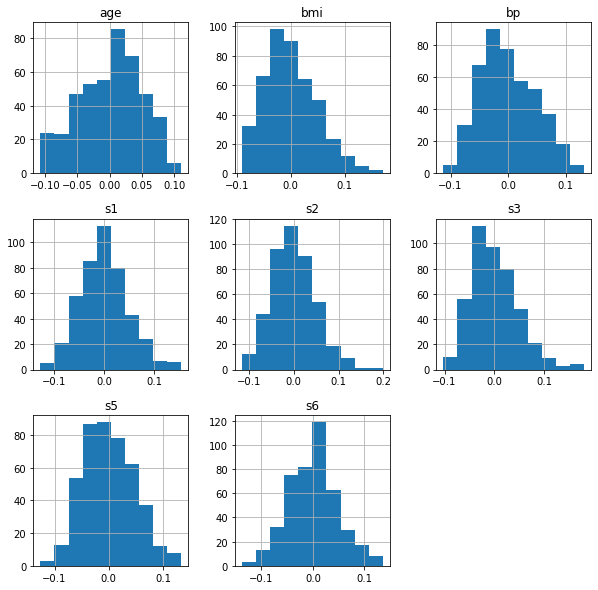

In [159]:
df_orig_data.hist(figsize=(10, 10));

There are nine columns of continuous data. There are no missing values.

Include all the columns in the list of features to be imputed.

In [160]:
impute_feature_list = df_orig_data.columns
impute_feature_list

Index(['age', 'bmi', 'bp', 's1', 's2', 's3', 's5', 's6'], dtype='object')

### Split the data set into training and test datasets

In [161]:
X_train, X_test, y_train, y_test = train_test_split(
    df_orig_data[impute_feature_list],
    df_target,
    test_size=0.25,
    random_state=0)

In [162]:
df_X_train = pd.DataFrame(X_train).reset_index(inplace=True, drop=True)
df_X_test = pd.DataFrame(X_test).reset_index(inplace=True, drop=True)
df_y_train = pd.DataFrame(y_train).reset_index(inplace=True, drop=True)
df_y_test = pd.DataFrame(y_test).reset_index(inplace=True, drop=True)

In [163]:
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

df_X_train.reset_index(inplace=True, drop=True)
df_X_test.reset_index(inplace=True, drop=True)
df_y_train.reset_index(inplace=True, drop=True)
df_y_test.reset_index(inplace=True, drop=True)

### Change random cells to missing values in the training and test datasets

In [164]:
np.random.seed(0)
p_miss = 0.2

df_X_train_miss = df_X_train.copy()
df_X_train_miss_loc = np.random.choice([True, False], size=df_X_train_miss.shape, p=(p_miss, 1 - p_miss))
df_X_train_miss[df_X_train_miss_loc] = np.nan

df_X_test_miss = df_X_test.copy()
df_X_test_miss_loc = np.random.choice([True, False], size=df_X_test_miss.shape, p=(p_miss, 1 - p_miss))
df_X_test_miss[df_X_test_miss_loc] = np.nan

In [165]:
df_X_train_miss.isna().sum()

age    60
bmi    61
bp     75
s1     72
s2     49
s3     63
s5     73
s6     72
dtype: int64

In [166]:
df_X_test_miss.isna().sum()

age    17
bmi    24
bp     26
s1     27
s2     26
s3     24
s5     16
s6     16
dtype: int64

### Set up a `torch`-based autoencoder

In [167]:
import torch
from torch import nn, optim
from torch.nn.modules import Module
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [168]:
class Autoencoder_Full(nn.Module):

    
    def __init__(self, encoding_layers, decoding_layers, input_size=2):
        super(Autoencoder_Full, self).__init__()
        
        self.encoding_layers = nn.ModuleList()
        next_input_size = input_size
        for size, activation in encoding_layers:
            self.encoding_layers.append(nn.Linear(next_input_size, size))
            next_input_size = size
            if activation is not None:
                assert isinstance(activation, Module), \
                    'Each tuple should contain a size (int) and a torch.nn.modules.Module.'
                self.encoding_layers.append(activation)
      
        self.decoding_layers = nn.ModuleList()
        for size, activation in decoding_layers:
            self.decoding_layers.append(nn.Linear(next_input_size, size))
            next_input_size = size
            if activation is not None:
                assert isinstance(activation, Module), \
                    'Each tuple should contain a size (int) and a torch.nn.modules.Module.'
                self.decoding_layers.append(activation)
                

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    

    def encode(self, x):
        for layer in self.encoding_layers:
            x = layer(x)
        return x
    
   
    def decode(self, x):
        for layer in self.decoding_layers:
            x = layer(x)
        return x

In [169]:
from copy import deepcopy

In [170]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, device='cpu', n_epochs=10, random_seed=0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    cost_list_train = []
    cost_list_valid = []
    
    # initialize model weights. this has been found to provide faster convergence initially.
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    model.apply(init_weights)
    
    for epoch in tqdm(range(n_epochs)):
        cost_train = 0
        for x_in in train_loader:
            x_in = x_in.to(device)
            model.train()
            optimizer.zero_grad()
            x_pred = model(x_in)
            loss = criterion(x_pred, x_in)
            loss.backward()
            optimizer.step()
            cost_train += loss.data
        cost_train = cost_train.cpu() / len(train_loader.dataset)
        cost_list_train.append(cost_train)
            
        # perform prediction on the validation data
        cost_valid = 0
        for x_in in valid_loader:
            x_in = x_in.to(device)
            model.eval()
            x_pred = model(x_in)
            loss = criterion(x_pred, x_in)
            cost_valid += loss.data
        cost_valid = cost_valid.cpu() / len(valid_loader.dataset)
        cost_list_valid.append(cost_valid)
        
        # save model if it is better
        if (epoch == 0):
            best_model = deepcopy(model)
            best_cost_valid = cost_valid
        elif cost_valid < best_cost_valid:
            best_model = deepcopy(model)
            best_cost_valid = cost_valid
        
    return best_model, cost_list_train, cost_list_valid

In [171]:
class Data(Dataset):
    
    
    def __init__(self, x):
        self.x = x
        w = ~torch.isnan(self.x) * 1
        x_na = torch.nan_to_num(x, 0)
        self.x = torch.hstack([x_na, w]).float()
        
        
    def __getitem__(self, index):
        return self.x[index,:]
    
    
    def __len__(self):
        return self.x.shape[0]
    
    
    def numvar(self):
        return self.x.shape[1]

In [172]:
class mse_with_missing(torch.nn.Module):

    
    def __init__(self):
        super(mse_with_missing, self).__init__()
        
    def forward(self, outputs, targets):
        weighted_sum_sq = (((outputs[:,:outputs.shape[1] // 2] - targets[:,:targets.shape[1] // 2]) ** 2) * targets[:,targets.shape[1] // 2:]).sum().sum()
        return weighted_sum_sq

### Scale the training and test datasets

In [173]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

In [174]:
# QuantileTransformer with 'uniform' is used here with satisfactory.
# Other options include QuantileTransformer with 'normal', MinMaxScaler and StandardScaler.
scaler = QuantileTransformer(output_distribution='uniform')

X_train = scaler.fit_transform(df_X_train_miss)
X_test = scaler.transform(df_X_test_miss)

C:\Users\ashut\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (331). n_quantiles is set to n_samples.
  warnings.warn(


In [175]:
# could use DEVICE = 'cuda' if appropriate for the problem
DEVICE = 'cpu'

### Prepare the datasets for training and evaluating the autoencoder

In [176]:
X_train = torch.tensor(X_train, device=DEVICE)
X_test = torch.tensor(X_test, device=DEVICE)

In [177]:
train_dataset = Data(X_train)
test_dataset = Data(X_test)

In [178]:
# memory is not an issue (on the machine that i am using) for this size problem.
# using a large batch_size as the training completes much more quickly.
train_loader = DataLoader(dataset=train_dataset, batch_size=1024)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024)

In [179]:
train_pred_list = []
test_pred_list = []

### Set up the autoencoder layers. No effort is made here to find the best configuration.

In [265]:
encoding_layers = [
#    (16, nn.Tanh()),
    (32, nn.Tanh()),
#    (64, nn.Tanh()),
#    (128, nn.Tanh()),
#    (256, nn.Tanh()),
#    (512, nn.Tanh()),
#    (256, nn.Tanh()),
#    (128, nn.Tanh()),
#    (64, nn.Tanh()),
    (32, nn.Tanh()),
    (16, nn.Tanh()),
    (1, None), # code size selected arbitrarily
]

In [266]:
decoding_layers = [
    (16, nn.Tanh()),
    (32, nn.Tanh()),
#    (64, nn.Tanh()),
#    (128, nn.Tanh()),
#    (256, nn.Tanh()),
#    (512, nn.Tanh()),
#    (256, nn.Tanh()),
#    (128, nn.Tanh()),
#    (64, nn.Tanh()),
    (32, nn.Tanh()),
#    (16, nn.Tanh()),
    (train_dataset.numvar(), None),
]

In [267]:
autoencoder = Autoencoder_Full(encoding_layers, decoding_layers, input_size=train_dataset.numvar())

In [268]:
autoencoder = autoencoder.to(DEVICE)

In [269]:
#criterion = nn.MSELoss()
criterion = mse_with_missing()

In [270]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [271]:
best_model, cost_list_train, cost_list_valid = train_model(autoencoder, train_loader, test_loader, optimizer, criterion,
                                               device=DEVICE, n_epochs=1000, random_seed=100)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.78it/s]


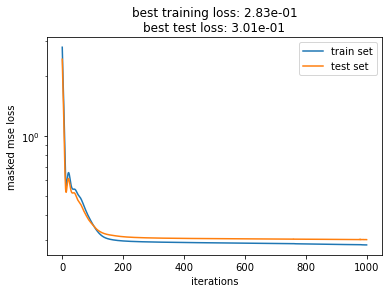

In [272]:
plt.plot(cost_list_train, label='train set')
plt.plot(cost_list_valid, label='test set')
plt.semilogy()
plt.xlabel('iterations')
plt.ylabel('masked mse loss')
plt.legend()
plt.title('best training loss: {:5.2e}\nbest test loss: {:5.2e}'.format(min(cost_list_train), min(cost_list_valid)))
plt.show();

In [273]:
# get the output of the autoencoder.
# only the first half of the columns are needed (the second half of columns correspond to missing data flags)
#X_train_pred = autoencoder(train_dataset[:]).detach().cpu().numpy()[:,:train_dataset.numvar() // 2]
#X_test_pred = autoencoder(test_dataset[:]).detach().cpu().numpy()[:,:test_dataset.numvar() // 2]

X_train_pred = best_model(train_dataset[:]).detach().cpu().numpy()[:,:train_dataset.numvar() // 2]
X_test_pred = best_model(test_dataset[:]).detach().cpu().numpy()[:,:test_dataset.numvar() // 2]

In [274]:
import math

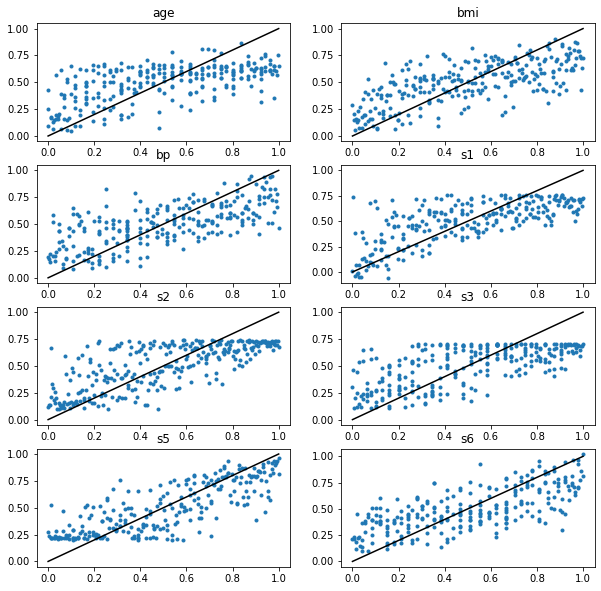

In [275]:
plt.figure(figsize=(10,10))
n_rows = math.ceil(X_train.shape[1] / 2)
n_cols = 2
for i in range(X_train.shape[1]):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_train[:,i].detach().cpu(), X_train_pred[:,i], marker='.')
    plt.plot([0,1], [0,1], color='black')
    plt.title(impute_feature_list[i])

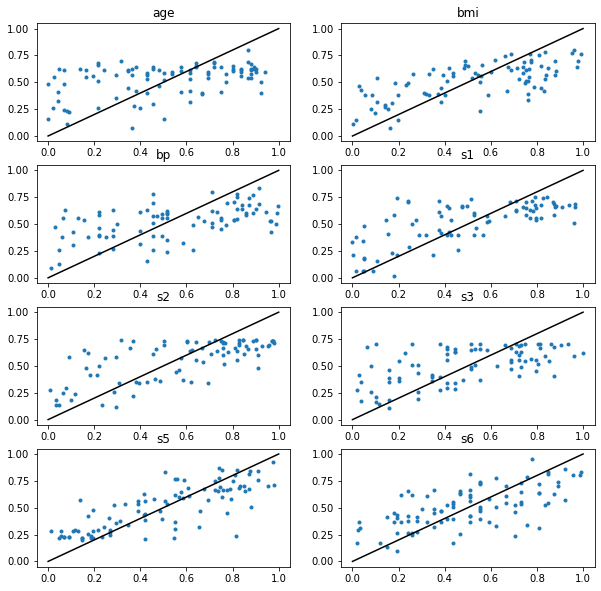

In [276]:
plt.figure(figsize=(10,10))
n_rows = math.ceil(X_train.shape[1] / 2)
n_cols = 2
for i in range(X_test.shape[1]):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_test[:,i].detach().cpu(), X_test_pred[:,i], marker='.')
    plt.plot([0,1], [0,1], color='black')
    plt.title(impute_feature_list[i])

In [277]:
df_X_train_imputed = pd.DataFrame(X_train_pred[:,:X_train_pred.shape[1]], columns=impute_feature_list)
df_X_test_imputed = pd.DataFrame(X_test_pred[:,:X_test_pred.shape[1]], columns=impute_feature_list)

In [278]:
df_X_train_imputed = scaler.inverse_transform(X_train_pred[:,:X_train_pred.shape[1]])
train_pred_list.append(df_X_train_imputed)
df_X_train_imputed = pd.DataFrame(df_X_train_imputed, columns=impute_feature_list)

df_X_test_imputed = scaler.inverse_transform(X_test_pred[:,:X_test_pred.shape[1]])
test_pred_list.append(df_X_test_imputed)
df_X_test_imputed = pd.DataFrame(df_X_test_imputed, columns=impute_feature_list)

C:\Users\ashut\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
C:\Users\ashut\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [279]:
df_X_train_err = df_X_train_imputed - df_X_train
df_X_test_err = df_X_test_imputed - df_X_test

df_X_train_miss_err = df_X_train_imputed - df_X_train_miss
df_X_test_miss_err = df_X_test_imputed - df_X_test_miss

In [280]:
df_X_train_miss_loc = pd.DataFrame(df_X_train_miss_loc, columns=df_X_train.columns)

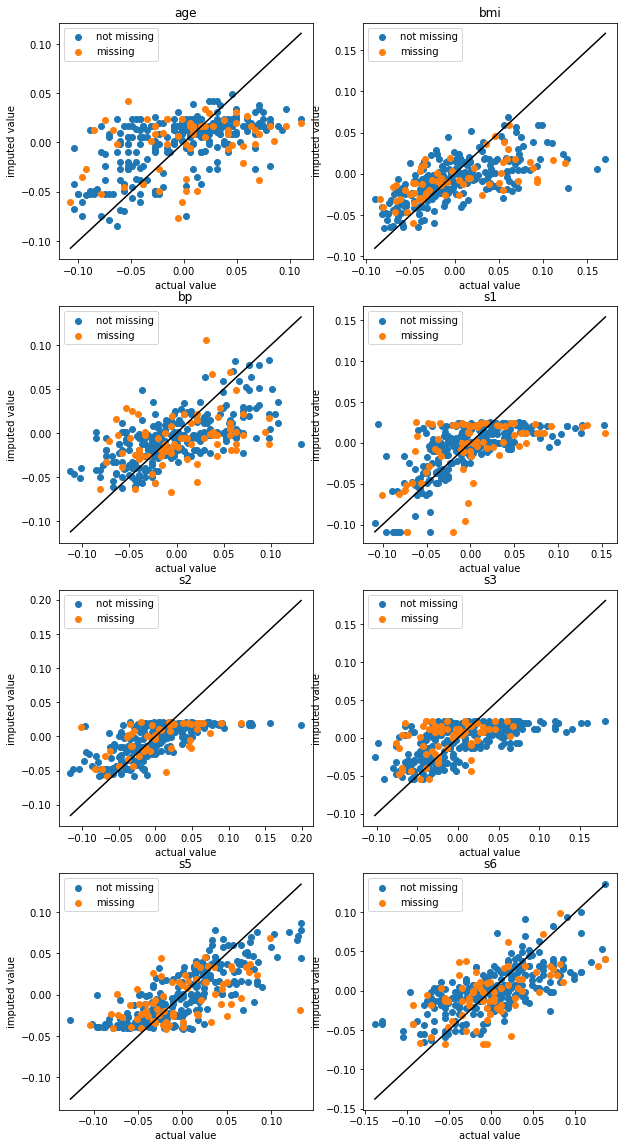

In [281]:
i = 1
plt.figure(figsize=(10, 20))
n_rows = math.ceil(len(df_X_train.columns) / 2)
n_cols = 2
for c in df_X_train.columns:
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df_X_train[~df_X_train_miss_loc[c]][c], df_X_train_imputed[~df_X_train_miss_loc[c]][c], label='not missing')
    plt.scatter(df_X_train[df_X_train_miss_loc[c]][c], df_X_train_imputed[df_X_train_miss_loc[c]][c], label='missing')
    xmin = min(df_X_train[df_X_train_miss_loc[c]][c].min(), 
               df_X_train[~df_X_train_miss_loc[c]][c].min(),
               df_X_train_imputed[df_X_train_miss_loc[c]][c].min(),
               df_X_train_imputed[~df_X_train_miss_loc[c]][c].min())
    xmax = max(df_X_train[df_X_train_miss_loc[c]][c].max(), 
               df_X_train[~df_X_train_miss_loc[c]][c].max(),
               df_X_train_imputed[df_X_train_miss_loc[c]][c].max(),
               df_X_train_imputed[~df_X_train_miss_loc[c]][c].max())
    plt.plot([xmin, xmax], [xmin, xmax], color='black')
    plt.xlabel('actual value')
    plt.ylabel('imputed value')
    plt.legend()
    plt.title(c)
    i += 1

In [282]:
sse = 0
for c in df_X_train.columns:
    sse += ((df_X_train[df_X_train_miss_loc[c]][c] - df_X_train_imputed[df_X_train_miss_loc[c]][c]) ** 2).sum().sum()
print('imputation error for missing values in train dataset: {}'.format(sse))

imputation error for missing values in train dataset: 0.9625239646456846


In [283]:
df_X_test_miss_loc = pd.DataFrame(df_X_test_miss_loc, columns=df_X_test.columns)

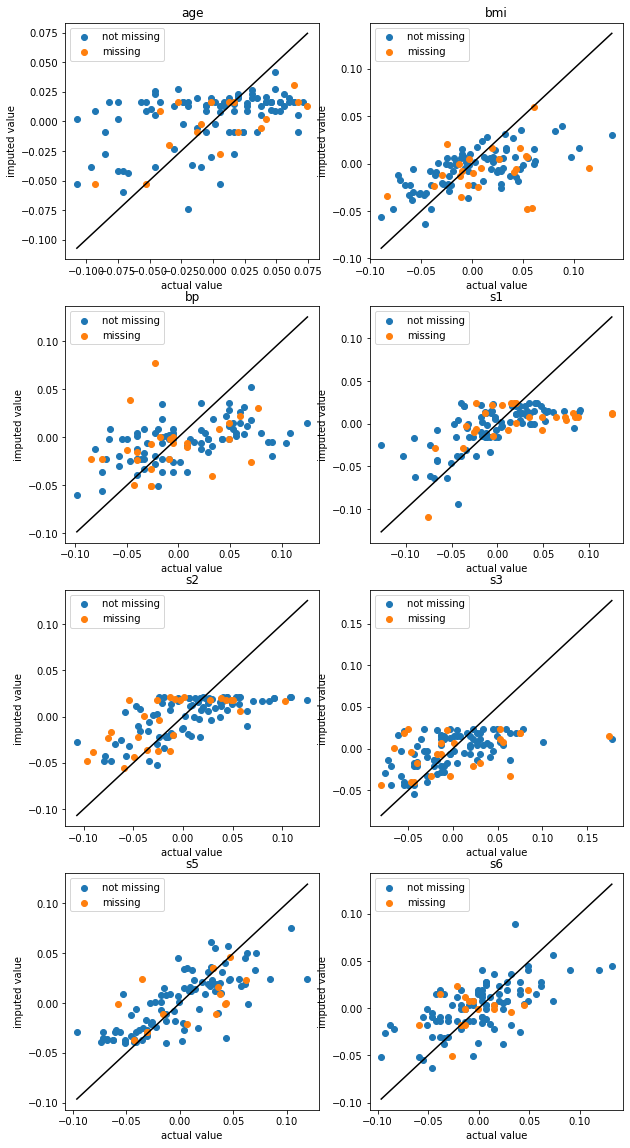

In [284]:
i = 1
plt.figure(figsize=(10, 20))
n_rows = math.ceil(len(df_X_train.columns) / 2)
n_cols = 2
for c in df_X_test.columns:
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df_X_test[~df_X_test_miss_loc[c]][c], df_X_test_imputed[~df_X_test_miss_loc[c]][c], label='not missing')
    plt.scatter(df_X_test[df_X_test_miss_loc[c]][c], df_X_test_imputed[df_X_test_miss_loc[c]][c], label='missing')
    xmin = min(df_X_test[df_X_test_miss_loc[c]][c].min(), 
               df_X_test[~df_X_test_miss_loc[c]][c].min(),
               df_X_test_imputed[df_X_test_miss_loc[c]][c].min(),
               df_X_test_imputed[~df_X_test_miss_loc[c]][c].min())
    xmax = max(df_X_test[df_X_test_miss_loc[c]][c].max(), 
               df_X_test[~df_X_test_miss_loc[c]][c].max(),
               df_X_test_imputed[df_X_test_miss_loc[c]][c].max(),
               df_X_test_imputed[~df_X_test_miss_loc[c]][c].max())
    plt.plot([xmin, xmax], [xmin, xmax], color='black')
    plt.xlabel('actual value')
    plt.ylabel('imputed value')
    plt.legend()
    plt.title(c)
    i += 1

In [285]:
sse = 0
for c in df_X_test.columns:
    sse += ((df_X_test[df_X_test_miss_loc[c]][c] - df_X_test_imputed[df_X_test_miss_loc[c]][c]) ** 2).sum().sum()
print('imputation error for missing values in test dataset: {}'.format(sse))

imputation error for missing values in test dataset: 0.3326846163100258


In [286]:
np.array(train_pred_list).shape

(4, 331, 8)

In [287]:
np.array(test_pred_list).shape

(4, 111, 8)

In [288]:
df_X_train_imputed_mean = pd.DataFrame(np.mean(np.array(train_pred_list), axis=0), columns=df_X_train.columns)
df_X_test_imputed_mean = pd.DataFrame(np.mean(np.array(test_pred_list), axis=0), columns=df_X_test.columns)

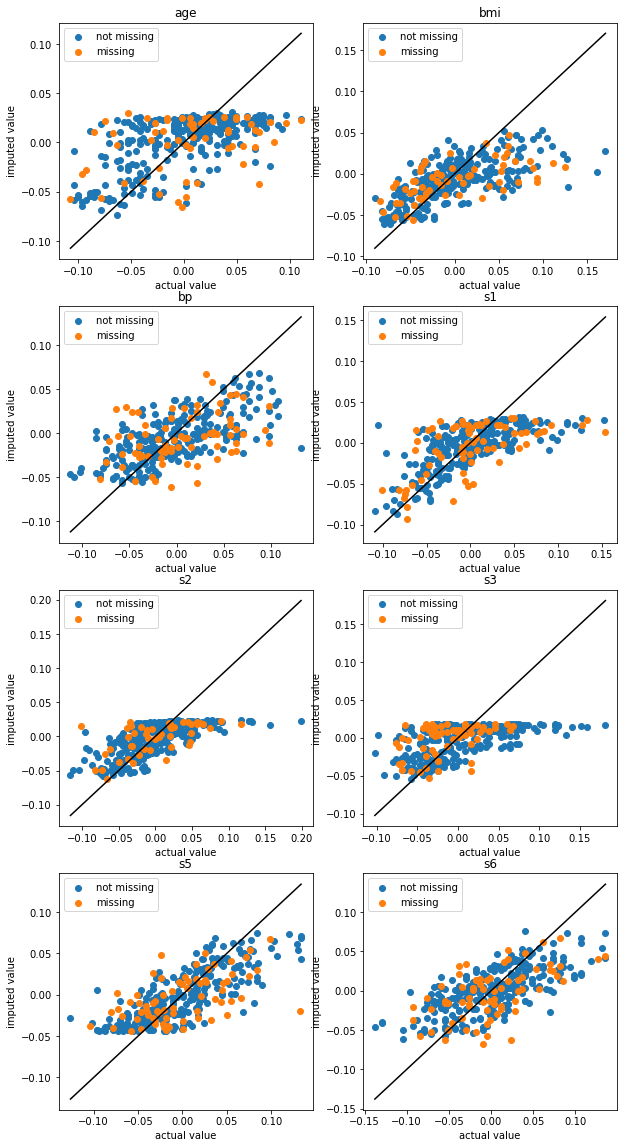

In [289]:
i = 1
plt.figure(figsize=(10, 20))
n_rows = math.ceil(len(df_X_train.columns) / 2)
n_cols = 2
for c in df_X_train.columns:
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df_X_train[~df_X_train_miss_loc[c]][c], df_X_train_imputed_mean[~df_X_train_miss_loc[c]][c], label='not missing')
    plt.scatter(df_X_train[df_X_train_miss_loc[c]][c], df_X_train_imputed_mean[df_X_train_miss_loc[c]][c], label='missing')
    xmin = min(df_X_train[df_X_train_miss_loc[c]][c].min(), 
               df_X_train[~df_X_train_miss_loc[c]][c].min(),
               df_X_train_imputed_mean[df_X_train_miss_loc[c]][c].min(),
               df_X_train_imputed_mean[~df_X_train_miss_loc[c]][c].min())
    xmax = max(df_X_train[df_X_train_miss_loc[c]][c].max(), 
               df_X_train[~df_X_train_miss_loc[c]][c].max(),
               df_X_train_imputed_mean[df_X_train_miss_loc[c]][c].max(),
               df_X_train_imputed_mean[~df_X_train_miss_loc[c]][c].max())
    plt.plot([xmin, xmax], [xmin, xmax], color='black')
    plt.xlabel('actual value')
    plt.ylabel('imputed value')
    plt.legend()
    plt.title(c)
    i += 1

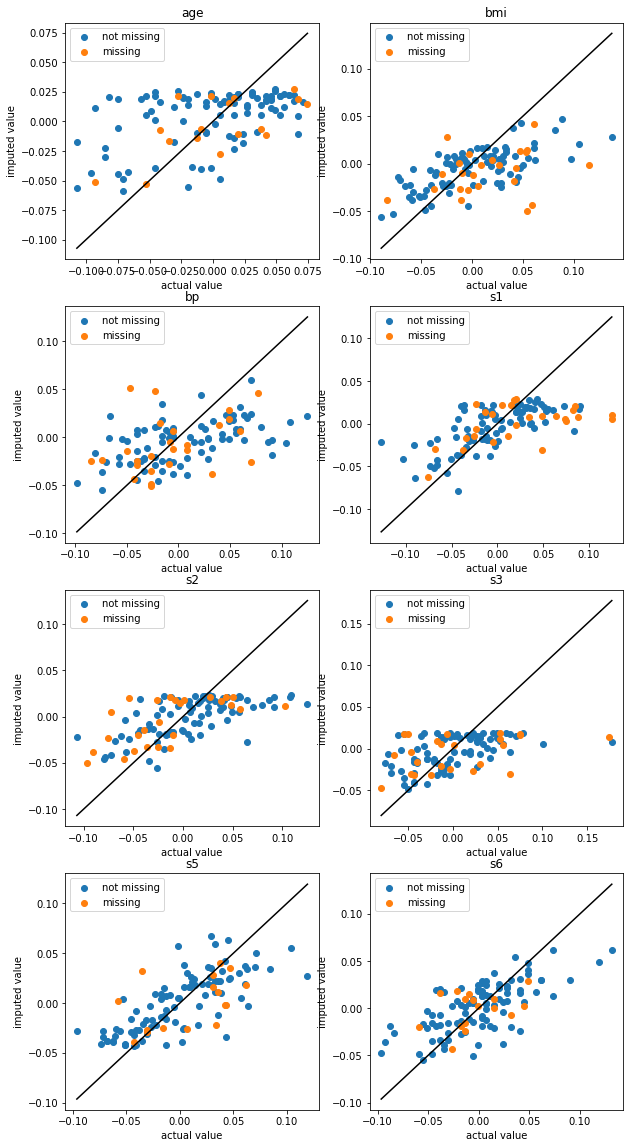

In [290]:
i = 1
plt.figure(figsize=(10, 20))
n_rows = math.ceil(len(df_X_test.columns) / 2)
n_cols = 2
for c in df_X_test.columns:
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df_X_test[~df_X_test_miss_loc[c]][c], df_X_test_imputed_mean[~df_X_test_miss_loc[c]][c], label='not missing')
    plt.scatter(df_X_test[df_X_test_miss_loc[c]][c], df_X_test_imputed_mean[df_X_test_miss_loc[c]][c], label='missing')
    xmin = min(df_X_test[df_X_test_miss_loc[c]][c].min(), 
               df_X_test[~df_X_test_miss_loc[c]][c].min(),
               df_X_test_imputed_mean[df_X_test_miss_loc[c]][c].min(),
               df_X_test_imputed_mean[~df_X_test_miss_loc[c]][c].min())
    xmax = max(df_X_test[df_X_test_miss_loc[c]][c].max(), 
               df_X_test[~df_X_test_miss_loc[c]][c].max(),
               df_X_test_imputed_mean[df_X_test_miss_loc[c]][c].max(),
               df_X_test_imputed_mean[~df_X_test_miss_loc[c]][c].max())
    plt.plot([xmin, xmax], [xmin, xmax], color='black')
    plt.xlabel('actual value')
    plt.ylabel('imputed value')
    plt.legend()
    plt.title(c)
    i += 1

In [291]:
sse = 0
for c in df_X_train.columns:
    sse += ((df_X_train[df_X_train_miss_loc[c]][c] - df_X_train_imputed_mean[df_X_train_miss_loc[c]][c]) ** 2).sum().sum()
print('imputation error for missing values in train dataset (MEAN): {}'.format(sse))

imputation error for missing values in train dataset (MEAN): 0.9221221705017443


In [292]:
sse = 0
for c in df_X_test.columns:
    sse += ((df_X_test[df_X_test_miss_loc[c]][c] - df_X_test_imputed_mean[df_X_test_miss_loc[c]][c]) ** 2).sum().sum()
print('imputation error for missing values in test dataset (MEAN): {}'.format(sse))

imputation error for missing values in test dataset (MEAN): 0.33437840837416766


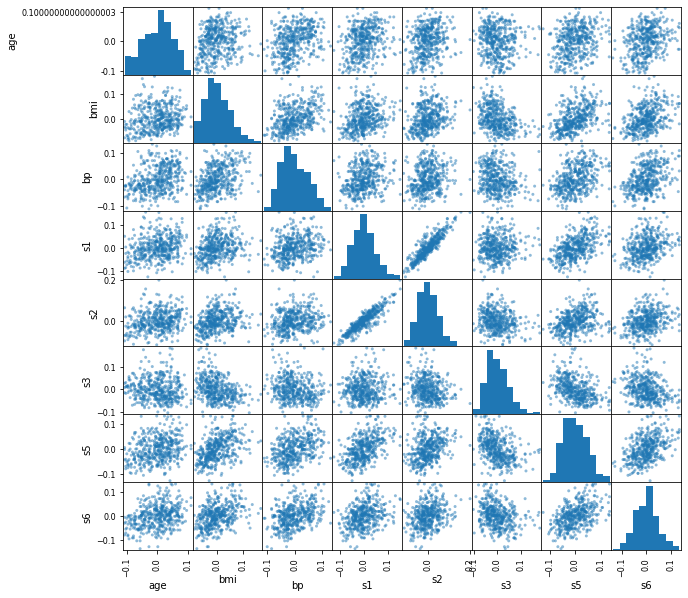

In [208]:
pd.plotting.scatter_matrix(df_orig_data, figsize=(10, 10));